# Análisis de Sentimientos a Nivel de Texto: Entrenamiento del modelo
---

> **Proyecto final de Asignatura Sistemas Computacionales <br>
Escuela de Ingeniería de Sistemas <br>
Universidad de Los Andes <br>
Autor: Jhonathan Abreu <br>**

---
<br>

La función del presente notebook es el entrenamiento del modelo a utilizar en la aplicación de análisis de sentimientos siendo desarrollada. El producto final de este notebook es un archivo en formato PKL, el cual corresponde a la persistencia del modelo generado y puede ser cargado en un futuro sin realizar el proceso de entrenamiento.

<br>

## Ingesta de la data
---

En primer lugar, se debe configurar el sistema de archivos de Google Drive:

In [1]:
# Instalar la biblioteca FUSE (Filesystem in Userspase) para manejar el sistema
# de archivos de Google Drive
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties \
    module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Importar bibliotecas necesarias para autenticación
from google.colab import auth
from oauth2client.client import GoogleCredentials
import getpass

# Generar los tokens de autorización para Colaboratory
auth.authenticate_user()

# Generar credenciales para la biblioteca FUSE
credentials = GoogleCredentials.get_application_default()

!google-drive-ocamlfuse -headless -id={credentials.client_id} \
    -secret={credentials.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={credentials.client_id} \
    -secret={credentials.client_secret}

# Montar sistema de archivos
!fusermount -u drive
!sshfs -u drive

# Crear un directorio y montar Google Drive usando ese directorio
!mkdir -p drive
!google-drive-ocamlfuse drive

# Prueba: mostrar contenido de un directorio en drive
print ('Archivos en Drive:')
!ls drive/ULA/sistemascomputacionales/entrega

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
fusermount: failed to unmount /content/drive: No such file or directory
/bin/sh: 1: sshfs: not found
Archivos en Drive:
aplicacion.ipynb  mejormodelo.ipynb  modelos
datasets	  modelo.ipynb	     preprocesamiento.ipynb


### Declaración de constantes

In [ ]:
import os

# Directorios de los datasets

#   NOTA: cambiar PROJECT_DIR al directorio raíz del proyecto
# Para drive:
#PROJECT_DIR = 'drive/ULA/sistemascomputacionales/entrega'
# Para local
PROJECT_DIR = ('/home/jhonathan/Documentos/ula/sistemas_computacionales/'
               'Proyecto_SistemasComputacionales_AbreuJ/aplicacion')
DATASETS_DIR = os.path.join(PROJECT_DIR, 'datasets')
ORIGINAL_DATASETS_DIR = os.path.join(DATASETS_DIR, 'originales')
PROCESSED_DATASETS_DIR = os.path.join(DATASETS_DIR, 'procesados')
MODELS_DIR = os.path.join(PROJECT_DIR, 'modelos')

### Carga de los datos

Ya se puede, entonces, proceder a cargar la data a utilizar, la cual ya fue preprocesada en el notebook `preprocesamiento.ipynb`:

In [2]:
import os
import pandas as pd

pd.set_option('display.max_colwidth', -1)

def ingest(datasetFileName):
    data = pd.read_csv(datasetFileName, header = None)
    data.columns = ['sentences', 'sentiment']
    data['sentiment'] = data['sentiment'].map({
                                                'positivo': 2,
                                                'neutral': 1,
                                                'negativo': 0
                                              })
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    print('dataset loaded with shape', data.shape)
    return data

datasetFileName = os.path.join(PROJECT_DIR,
                               'datasets/procesados/labeled_data.csv')
data = ingest(datasetFileName)
display(data.head())

dataset loaded with shape (600, 2)


,sentences,sentiment
0,"La canción que acaba de sacar Sia es muy buena, suena muy bien",2
1,"La música de Maluma es realmente mala y sin sentido, no se como es que a las persona les gusta",0
2,Hoy es un día normal y tranquilo,1
3,Que bello día,2
4,Estoy enojado contigo,0


## El Modelo
---

Para el análisis de sentimientos se va a utilzar un clasificador de tipo Red Neuronal Convolucional y un vectorizador tipo Bag-of-Words.
<br>
### Representación vectorial de las frases

En este caso, se va a utilizar el modelo típico conocido como Bag-Of-Words, el cual permite de un texto (como una oración) sea representada como una colección (bolsa) de sus palabras, sin importar la gramática o el orden de las palabras, pero manteniendo la multiplicidad. La biblioteca de aprendizaje automático [scikit-learn](http://scikit-learn.org/stable/index.html) de Python provee un modelo llamado `CounterVectorizer`, el cual abstrae el proceso de tokenización, conteo y vectorización de las frases o documentos (además de otros procedimientos de limpieza) mediante el modelo Bag-Of-Words. Más información sobre el `CounterVectorizer` y el proceso de vectorización [aquí](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) y [aquí](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

Se va a utilizar un `CounterVectorizer` para este fin, para lo cual es necesario que este realize los siguientes pasos:

1.   Eliminar símbolos (puntuación, números, entre otros) de las frases.
2.   Tokenizar la frase.
3.   Eliminar las palabras vacías.
4.   Aplicar el stemming: este es el proceso en el que se convierten las palabras a su raíz. Por ejemplo, si en el vocabulario se encuentra la palabra "bibliotec**as**", la palabra que entra a la bolsa de palabras es su raíz "bibliotec", de modo que si se intenta clasificar una frase que contenga la palabra "bibliotec**ario**" (que no está en el vocabulario), esta se tome en cuenta en el análisis.
5.   Eliminar acentos.
6.   Construir el modelo y vectorizar la frase.

Antes de codificar lo anterior, es necesario descargar la lista de palabras vacías que provee [NLTK](https://www.nltk.org/) y extender la lista de signos de puntuación que provee el módulo string de Python, agregándole los signos de puntuación propios del lenguaje Español y los números:

In [4]:
# Descarga y carga de la lista de palabras vacías de NLTK
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

nltk.download('stopwords')
spanishStopWords = stopwords.words('spanish')

# Carga y extensión de la lista de signos de puntuación y otros símbolos.
from string import punctuation

nonWords = list(punctuation)
nonWords.extend(['¿', '¡'])  # Se agregan estos símbolos (español)
nonWords.extend(map(str,range(10)))  # Se agregan los dígitos numéricos

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<br>
#### Limpieza de las oraciones
Para los **pasos 2-5** se utlizara la biblioteca de procesamiento de lenguaje natural NLTK. Específicamente para el paso 4, se utilizará la clase SnowballStemmer.

Las siguientes funciones resumen los pasos 1-5:

In [ ]:
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer

import numpy as np

# Stemmer, objeto que llevará las palabras a sus raíces 
stemmer = SnowballStemmer('spanish')

# Función que aplica el stemming
def stem_tokens(tokens, stemmer):
    stemmedTokens = []
    for token in tokens:
        stemmedTokens.append(stemmer.stem(token))
        
    return stemmedTokens

# Función que limpia y tokeniza las frases
def tokenize(text):
    # Eliminación de símbolos y números
    text = ''.join([c for c in text if c not in nonWords])
    # Tokeninazión
    tokens =  word_tokenize(text)

    # Stemming
    try:
        stemmedTokens = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stemmedTokens = ['']
        
    return stemmedTokens

<br>
#### Construcción del vectorizador

Por último, el vectorizador se construye de la siguiente manera:

In [ ]:
# Vectorizador:
#   Se construyen los vectores a nivel de palabras
#   Se utiliza la funcion tokenize (ver arriba) como tokenizador.
#   Se convierten todas las letras a minúsculas.
#   Se eliminan los acentos en los caracteres unicode.
#   Se se provee la lista de palabras vacías de arriba para ser eliminadas.
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize,
                             lowercase = True, strip_accents = 'unicode',
                             stop_words = spanishStopWords, ngram_range = (1,2))

<br>

### El Clasificador 

El modelo a ser utilizado es una Red Neuronal Convolucional. La implementación a ser utilizada es la proporcionada por [Keras](https://keras.io/models/sequential/).

DESCRIBIR ARQUITECTURA

El primer paso es definir la arquitectura del modelo a utilizar, el cual fue el resultado de experimentos manuales realizados hasta encontrar la red que dió los mejores resultados. 

In [ ]:
import numpy as np 
import pandas as pd
import os.path
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D

def buildModel(inputDimension):
    model = Sequential()
    
    model.add(Conv1D(128, 1, input_shape = (1, inputDimension),
                     activation = 'relu'))
    model.add(Conv1D(32, 1, activation = 'relu'))
    
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))    
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(3, activation = 'sigmoid'))
    
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    return model

### División de la data de entrenamiento y pruebas

Debido a la poca cantidad de datos disponibles, se tomará una proporción 9:1 para data de entrenamiento y pruebas.


In [34]:
from sklearn.model_selection import train_test_split

trainSentences, testSentences, trainLabels, testLabels = \
    train_test_split(np.array(data.sentences), np.array(data.sentiment),
                     test_size = 0.15, stratify = np.array(data.sentiment),
                     random_state = 27)

print('Cantidad de oraciones de entrenamiento: {}'.format(len(trainSentences)))
print('Cantidad de oraciones de prueba: {}'.format(len(testSentences)))

Cantidad de oraciones de entrenamiento: 510
Cantidad de oraciones de prueba: 90


### Entrenamiento del vectorizador

El vectorizador debe ser entrenado con los mismos datos de entranamiento del clasificador. Se aprovecha también para salvar este modelo para ser usado luego en la aplicación de predicción:

In [35]:
from sklearn.externals import joblib

# Entrenamiento
vectorizer.fit(trainSentences)

# Persistencia del modelo
vectorizerFileName = os.path.join(MODELS_DIR, 'vectorizador.pkl')
joblib.dump(vectorizer, vectorizerFileName)

['drive/ULA/sistemascomputacionales/entrega/modelos/vectorizador.pkl']

<br>
Ahora si se pueden tansformar las oraciones a vectores.

Se debe mencionar que las redes neuronales convolucionales de Keras requieren que los datos tengan la siguiene forma o shape:

> (nVectores, pasos, dimensiónVectores)

Los *pasos* indican la cantidad de elementos a ver en cada paso del entrenamiento, siendo, en este caso, un vector a la vez, sin combinarlos. De igual manera, las etiquetas deben convertirse en matrices binarias (lo cual se conoce como codificación One-Hot):


In [36]:
# Oraciones a vectores
trainVectors = vectorizer.transform(trainSentences).toarray()
testVectors = vectorizer.transform(testSentences).toarray()
print('Dimensión de los vectores: ', trainVectors.shape[1])

# Redimensionando los vectores para ser alimentados a la RNC
trainVectors = trainVectors.reshape((trainVectors.shape[0], 1,
                                     trainVectors.shape[1]))
testVectors = testVectors.reshape((testVectors.shape[0], 1,
                                   testVectors.shape[1]))

# Conversión de las etiquetas (One-Hot)
trainLabels = keras.utils.np_utils.to_categorical(trainLabels, 3)
testLabels = keras.utils.np_utils.to_categorical(testLabels, 3)

Dimensión de los vectores:  3933


### Entrenamiento del clasificador

Para esta tarea, el método de entranamiento obtiene el modelo con la mejor precisión y lo escribe persistentemente en un archivo. Para esta optimización, primero se deben definir algunos métodos  (llamados callbacks) para generar este comportamiento:

1.   Un método que se encargue de escribir en un archivo el mejor modelo
2.   Uno para reducir la taza de aprendizaje cuando este se estanque
3.   Otro para detener el entrenamiento cuando el modelo ya haya alcanzado un posible óptimo y se espere que no aumente su precisión, sin realizar todas las iteraciones.



In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

modelFileName = os.path.join(MODELS_DIR, 'modelo.hdf5')

# Checkpoint (número 1 en la lista anterior)
checkpointer = ModelCheckpoint(filepath = modelFileName, 
                               monitor = 'val_acc', verbose = 1,
                               save_best_only = True, mode = 'auto')

# Reducción de taza de aprendizaje (número 2 de la lista anterior)
learningRateReducer = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.2,
                                        patience = 5, min_lr = 0.001)

# Detener el entrenamiento al alcanzar el "óptimo"
# (número 3 de la lista anterior)
earlyStop = EarlyStopping(monitor = 'val_acc', patience = 100, verbose = 1,
                          mode = 'auto')

<br>
Ya está todo preparado para entrenar el clasificador:

In [38]:
model = buildModel(trainVectors.shape[2])
model.fit(trainVectors, trainLabels, batch_size = 32,
           validation_data = (testVectors, testLabels), epochs = 1000,
           callbacks = [checkpointer, learningRateReducer, earlyStop],
           verbose = 2, shuffle = False)

Train on 510 samples, validate on 90 samples
Epoch 1/1000
 - 1s - loss: 0.6699 - acc: 0.6503 - val_loss: 0.6443 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to drive/ULA/sistemascomputacionales/entrega/modelos/modelo.hdf5
Epoch 2/1000
 - 0s - loss: 0.6382 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667

Epoch 00002: val_acc did not improve from 0.66667
Epoch 3/1000
 - 0s - loss: 0.6172 - acc: 0.6667 - val_loss: 0.6269 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/1000
 - 0s - loss: 0.5688 - acc: 0.6817 - val_loss: 0.6018 - val_acc: 0.6815

Epoch 00004: val_acc improved from 0.66667 to 0.68148, saving model to drive/ULA/sistemascomputacionales/entrega/modelos/modelo.hdf5
Epoch 5/1000
 - 0s - loss: 0.4621 - acc: 0.7627 - val_loss: 0.5589 - val_acc: 0.7037

Epoch 00005: val_acc improved from 0.68148 to 0.70370, saving model to drive/ULA/sistemascomputacionales/entrega/modelos/modelo.hdf5
Epoch 6/1000
 - 0s - loss: 0.

## Evaluación del modelo
---

La primera evaluación será observar la exactitud de las pruebas para este modelo, así que carga del archivo y se evalúan los datos de prueba:

In [39]:
# Contrucción del modelo
model = buildModel(trainVectors.shape[2])

# Carga delos pesos
model.load_weights(modelFileName)
scores = model.evaluate(testVectors, testLabels, verbose = 1)

print('Pérdida de las pruebas: ', scores[0])
print('Exactitud de las pruebas : ', scores[1])

90/90 [==============================] - 0s 2ms/step
Pérdida de las pruebas:  1.9698952635129292
Exactitud de las pruebas :  0.8037037120925056


### Matriz de confusión

Esta herramienta permite, de forma gráfica, observar el desempeño del clasificador, al mostrar la cantidad de  veces que este acertó o se equivocó, mediante un mapa de calor:

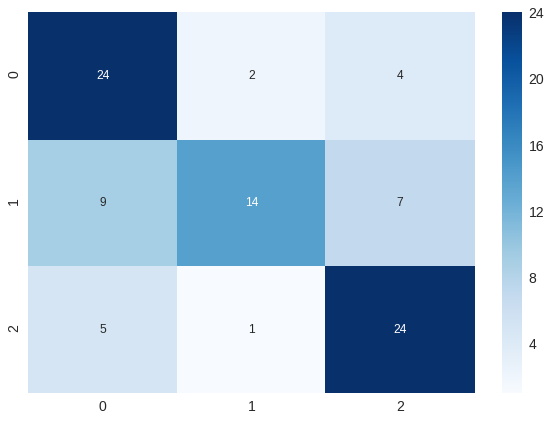

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn

predictions = model.predict(testVectors, verbose=2)
predictions = np.argmax(predictions, axis = 1)
confusionMatrix = confusion_matrix(np.argmax(testLabels, axis = 1), predictions)

confusionMatrixDataFrame = pd.DataFrame(confusionMatrix, range(3), range(3))
plot.figure(figsize = (10, 7))
sn.set(font_scale = 1.4)
sn.heatmap(confusionMatrixDataFrame, annot = True, annot_kws = {'size': 12},
           fmt = 'g', cmap = 'Blues')
plot.show()